In [0]:
%matplotlib inline

In [0]:
import numpy as np
from scipy.linalg import norm, lstsq

# Orthogonal matching pursuit (OMP)
def OMP(A, b, delta=1e-6, maxnnz=None):
    m, n = A.shape
    if maxnnz is None: maxnnz = m // 2
    r = b.copy()
    x = np.zeros(n, dtype=b.dtype)
    supp = []
    while len(supp) < maxnnz and norm(r) > delta:
        s = np.argmax(np.abs(A.T.dot(r)))
        supp.append(s)
        Asupp = A[:,supp]
        x[supp] = lstsq(Asupp, b)[0]
        r = b - Asupp.dot(x[supp])
    return x

In [4]:
from time import time
# Generate sythetic data for demo
rng = np.random.RandomState(int(time()))
#m, n = 128, 256
#m, n = 256, 512
#m, n = 512, 2048
#m, n = 1024, 8192
m, n = 2000, 4000
dtype = np.float64  # try np.float32 and np.float64

# use a random matrix as a basis
A = rng.randn(m, n).astype(dtype) / np.sqrt(m)

# generate a k-sparse Gaussian signal vector
k = 298
stdx = 1.
snr = 10.  # try 20., 10., 5., np.inf

x_true = np.zeros(n, dtype=dtype)
T = np.sort(rng.choice(n,k,replace=False))
print('True support of %d nonzeros = ' % (k))
print(T)
x_true[T] = rng.randn(k).astype(dtype) * stdx

# make the query vector
b = A.dot(x_true)

# add noise
if np.isinf(snr):
    noise = 0.
else:
    normb = norm(b)
    noise = rng.randn(m).astype(dtype)
    noise = noise / norm(noise) * normb / snr
    b = b + noise

tol = norm(noise)

True support of 298 nonzeros = 
[  15   30   48   69   72  150  169  186  188  235  261  276  279  281
  288  298  300  334  339  348  349  372  381  388  404  405  432  435
  445  464  496  502  504  522  539  553  577  578  586  599  614  625
  640  650  651  665  689  713  762  766  774  785  825  852  857  861
  885  892  908  909  924  933  943  944  952  956  972  974  994 1001
 1002 1009 1029 1049 1050 1073 1074 1083 1101 1103 1104 1127 1135 1141
 1154 1166 1174 1191 1244 1246 1250 1260 1266 1277 1289 1316 1317 1318
 1328 1339 1341 1380 1394 1395 1399 1400 1405 1411 1413 1428 1444 1446
 1524 1530 1560 1563 1583 1585 1588 1595 1603 1621 1624 1645 1646 1677
 1679 1697 1703 1709 1712 1735 1743 1757 1759 1760 1781 1782 1784 1785
 1798 1807 1812 1851 1861 1864 1867 1899 1924 1928 1930 1948 1976 1988
 2010 2013 2019 2022 2032 2050 2062 2075 2085 2096 2111 2129 2135 2158
 2160 2162 2165 2166 2188 2189 2212 2239 2271 2290 2315 2332 2368 2377
 2393 2394 2416 2417 2422 2426 2448 2454 2468

In [5]:
# OMP
print("Running OMP..")
t0 = time()
x_est = OMP(A, b, delta=tol)
#x_est = OMP(A, b)  # noiseless case (snr=np.inf)
print('done in %.2fs.' % (time() - t0))

Tpred = np.nonzero(x_est)[0]
print('Predicted supprt of %d nonzeros = ' % (np.count_nonzero(x_est)))
print(Tpred)

from sklearn import metrics
print(metrics.classification_report(x_true == 0, x_est == 0))
print(metrics.confusion_matrix(x_true == 0, x_est == 0))

Running OMP..
done in 16.95s.
Predicted supprt of 254 nonzeros = 
[  15   30   48   69   72  150  169  186  188  261  279  281  288  298
  334  339  349  372  381  388  404  432  435  445  464  496  502  504
  522  539  553  578  586  599  614  625  640  651  665  689  713  762
  766  774  785  825  852  857  861  885  892  908  909  924  933  943
  944  952  956  972  974 1002 1009 1029 1049 1050 1073 1074 1083 1101
 1103 1104 1135 1141 1154 1166 1174 1191 1244 1246 1250 1260 1266 1277
 1289 1317 1318 1339 1341 1380 1394 1399 1405 1411 1413 1428 1444 1446
 1524 1530 1560 1563 1583 1585 1595 1603 1621 1624 1645 1646 1677 1679
 1697 1703 1709 1712 1735 1743 1757 1759 1781 1782 1784 1785 1798 1807
 1812 1861 1864 1867 1899 1924 1930 1976 2010 2019 2022 2032 2050 2075
 2096 2111 2129 2135 2158 2160 2166 2188 2189 2212 2271 2290 2332 2368
 2393 2394 2416 2417 2422 2426 2448 2454 2468 2471 2489 2492 2495 2499
 2514 2528 2567 2587 2599 2634 2638 2645 2647 2674 2676 2682 2687 2699
 2733 2736 

In [0]:
import numpy as np
from scipy.linalg import norm, qr_insert, solve_triangular

# Orthogonal matching pursuit with QR factorization (OMPQR)
def OMPQR(A, b, delta=1e-6, maxnnz=None):
    m, n = A.shape
    if maxnnz is None: maxnnz = m // 2
    r = b.copy()

    # find the 1st atom and orthonormal basis
    s = np.argmax(np.abs(A.T.dot(r)))
    R = np.atleast_2d(norm(A[:,s])).astype(A.dtype)
    Q = np.atleast_2d(A[:,s] / R).astype(A.dtype).T
    xi = Q[:,-1].dot(b)
    r -= xi * Q[:,-1]
    xnz = [xi]
    supp = [s]

    while len(supp) < maxnnz and norm(r) > delta:
        s = np.argmax(np.abs(A.T.dot(r)))
        Q, R = qr_insert(Q, R, A[:,s], Q.shape[1], which='col')
        xi = Q[:,-1].dot(b)
        r -= xi * Q[:,-1]
        xnz.append(xi)
        supp.append(s)

    xnz = solve_triangular(R, xnz)
    x = np.zeros(n)
    x[supp] = xnz
    return x

In [7]:
# OMPQR
print("Running OMPQR..")
t0 = time()
x_est = OMPQR(A, b, delta=tol)
#x_est = OMPQR(A, b)  # noiseless case (snr=np.inf)
print('done in %.2fs.' % (time() - t0))

Tpred = np.nonzero(x_est)[0]
print('Predicted supprt of %d nonzeros = ' % (np.count_nonzero(x_est)))
print(Tpred)

from sklearn import metrics
print(metrics.classification_report(x_true == 0, x_est == 0))
print(metrics.confusion_matrix(x_true == 0, x_est == 0))

Running OMPQR..
done in 3.78s.
Predicted supprt of 254 nonzeros = 
[  15   30   48   69   72  150  169  186  188  261  279  281  288  298
  334  339  349  372  381  388  404  432  435  445  464  496  502  504
  522  539  553  578  586  599  614  625  640  651  665  689  713  762
  766  774  785  825  852  857  861  885  892  908  909  924  933  943
  944  952  956  972  974 1002 1009 1029 1049 1050 1073 1074 1083 1101
 1103 1104 1135 1141 1154 1166 1174 1191 1244 1246 1250 1260 1266 1277
 1289 1317 1318 1339 1341 1380 1394 1399 1405 1411 1413 1428 1444 1446
 1524 1530 1560 1563 1583 1585 1595 1603 1621 1624 1645 1646 1677 1679
 1697 1703 1709 1712 1735 1743 1757 1759 1781 1782 1784 1785 1798 1807
 1812 1861 1864 1867 1899 1924 1930 1976 2010 2019 2022 2032 2050 2075
 2096 2111 2129 2135 2158 2160 2166 2188 2189 2212 2271 2290 2332 2368
 2393 2394 2416 2417 2422 2426 2448 2454 2468 2471 2489 2492 2495 2499
 2514 2528 2567 2587 2599 2634 2638 2645 2647 2674 2676 2682 2687 2699
 2733 2736

In [0]:
import numpy as np
from scipy.linalg import norm, lstsq

# Generalized orthogonal matching pursuit (gOMP)
def gOMP(A, b, N=3, delta=1e-6, maxiter=None):
    m, n = A.shape
    if maxiter is None: maxiter = m // N
    r = b.copy()
    x = np.zeros(n, dtype=b.dtype)
    supp = []
    #supp = np.array([], dtype=int)

    count = 0
    while count < maxiter and norm(r) > delta:
        count += 1
        s = np.argsort(-np.abs(A.T.dot(r)))
        supp.extend(s[:N])
        #supp = np.union1d(supp, s[:N])
        Asupp = A[:,supp]
        x[supp] = lstsq(Asupp, b)[0]
        r = b - Asupp.dot(x[supp])
    x[np.abs(x) < np.spacing(np.float32(1.0))] = 0.
    return x

In [9]:
# gOMP
print("Running gOMP..")
t0 = time()
x_est = gOMP(A, b, N=6, delta=tol)
#x_est = gOMP(A, b, N=6)  # noiseless case (snr=np.inf)
print('done in %.2fs.' % (time() - t0))

Tpred = np.nonzero(x_est)[0]
print('Predicted supprt of %d nonzeros = ' % (np.count_nonzero(x_est)))
print(Tpred)

from sklearn import metrics
print(metrics.classification_report(x_true == 0, x_est == 0))
print(metrics.confusion_matrix(x_true == 0, x_est == 0))

Running gOMP..
done in 3.07s.
Predicted supprt of 258 nonzeros = 
[  15   30   48   69   72  150  169  186  188  261  279  281  288  298
  334  339  349  372  381  388  404  432  435  445  464  496  502  504
  522  539  553  578  586  599  614  625  640  651  665  689  713  762
  766  774  785  825  852  857  861  885  892  908  909  924  933  943
  944  952  956  972  974 1002 1009 1029 1049 1050 1073 1074 1083 1101
 1103 1104 1135 1141 1154 1166 1174 1191 1244 1246 1250 1260 1266 1277
 1289 1317 1318 1339 1341 1380 1394 1395 1399 1405 1411 1413 1428 1444
 1446 1524 1530 1560 1563 1583 1585 1595 1603 1621 1624 1645 1646 1677
 1679 1697 1703 1709 1712 1735 1743 1757 1759 1781 1782 1784 1785 1798
 1807 1812 1861 1864 1867 1899 1924 1930 1976 2010 2019 2022 2032 2050
 2075 2096 2111 2129 2135 2158 2160 2166 2188 2189 2212 2271 2290 2332
 2368 2393 2394 2416 2417 2422 2426 2448 2454 2468 2471 2489 2492 2495
 2499 2514 2528 2567 2587 2599 2634 2638 2645 2647 2674 2676 2682 2687
 2699 2733 

In [0]:
import numpy as np
from scipy.linalg import norm, qr, qr_insert, solve_triangular

# Generalized orthogonal matching pursuit with QR factorization (gOMPQR)
def gOMPQR(A, b, N=3, delta=1e-6, maxiter=None):
    m, n = A.shape
    if maxiter is None: maxiter = m // N
    r = b.copy()

    # find the 1st atom group and orthonormal basis
    s = np.argsort(-np.abs(A.T.dot(r)))
    Q, R = qr(A[:,s[:N]], mode='economic')
    xi = Q.T.dot(b)
    r -= Q.dot(xi)
    xnz = xi.tolist()
    supp = s[:N].tolist()
    
    count = 1
    while count < maxiter and norm(r) > delta:
        count += 1
        s = np.argsort(-np.abs(A.T.dot(r)))
        Q, R = qr_insert(Q, R, A[:,s[:N]], Q.shape[1], which='col')
        xi = Q[:,-N:].T.dot(b)
        r -= Q[:,-N:].dot(xi)
        xnz.extend(xi)
        supp.extend(s[:N])

    xnz = solve_triangular(R, xnz)
    xnz[np.abs(xnz) < np.spacing(np.float32(1.0))] = 0.
    x = np.zeros(n)
    x[supp] = xnz
    return x

In [11]:
# gOMPQR
print("Running gOMPQR..")
t0 = time()
x_est = gOMPQR(A, b, N=6, delta=tol)
#x_est = gOMPQR(A, b, N=6, maxiter=min(k,m//6))
#x_est = gOMPQR(A, b, N=6)  # noiseless case (snr=np.inf)
print('done in %.2fs.' % (time() - t0))

Tpred = np.nonzero(x_est)[0]
print('Predicted supprt of %d nonzeros = ' % (np.count_nonzero(x_est)))
print(Tpred)

from sklearn import metrics
print(metrics.classification_report(x_true == 0, x_est == 0))
print(metrics.confusion_matrix(x_true == 0, x_est == 0))

Running gOMPQR..
done in 0.74s.
Predicted supprt of 258 nonzeros = 
[  15   30   48   69   72  150  169  186  188  261  279  281  288  298
  334  339  349  372  381  388  404  432  435  445  464  496  502  504
  522  539  553  578  586  599  614  625  640  651  665  689  713  762
  766  774  785  825  852  857  861  885  892  908  909  924  933  943
  944  952  956  972  974 1002 1009 1029 1049 1050 1073 1074 1083 1101
 1103 1104 1135 1141 1154 1166 1174 1191 1244 1246 1250 1260 1266 1277
 1289 1317 1318 1339 1341 1380 1394 1395 1399 1405 1411 1413 1428 1444
 1446 1524 1530 1560 1563 1583 1585 1595 1603 1621 1624 1645 1646 1677
 1679 1697 1703 1709 1712 1735 1743 1757 1759 1781 1782 1784 1785 1798
 1807 1812 1861 1864 1867 1899 1924 1930 1976 2010 2019 2022 2032 2050
 2075 2096 2111 2129 2135 2158 2160 2166 2188 2189 2212 2271 2290 2332
 2368 2393 2394 2416 2417 2422 2426 2448 2454 2468 2471 2489 2492 2495
 2499 2514 2528 2567 2587 2599 2634 2638 2645 2647 2674 2676 2682 2687
 2699 273

rel. error = 5.80e-02


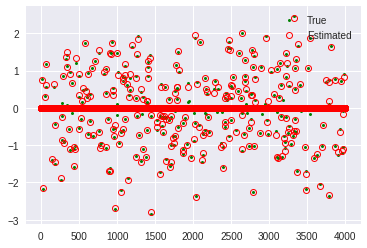

In [12]:
print('rel. error = %.2e' % (norm(x_est-x_true)/norm(x_true)))
import matplotlib.pyplot as plt
plt.figure()
plt.plot(np.arange(n), x_true, 'g.', markersize=6, mec='green', label='True')
plt.plot(np.arange(n), x_est, 'ro', mfc = 'None', markersize=6, mec='red', mew=1, label='Estimated')
plt.legend(loc='upper right', shadow=False)
plt.show()

In [13]:
%timeit -r 4 -n 10 gOMPQR(A, b, N=3,delta=tol)

10 loops, best of 4: 1.37 s per loop


In [14]:
#m, n = 512, 1024
m, n = 128, 256
reconsts = {'test_count': 0, 'shape': (m,n), 'nnz': range(5, (3*m)//4, 10)}
for alg in ['OMP', 'gOMP3', 'gOMP6', 'gOMP9']:
    reconsts[alg] = {'success': {}, 'time': {}}
    for k in reconsts['nnz']:
        reconsts[alg]['success'][k] = 0
        reconsts[alg]['time'][k] = 0
print(reconsts)

{'test_count': 0, 'shape': (128, 256), 'nnz': range(5, 96, 10), 'OMP': {'success': {5: 0, 15: 0, 25: 0, 35: 0, 45: 0, 55: 0, 65: 0, 75: 0, 85: 0, 95: 0}, 'time': {5: 0, 15: 0, 25: 0, 35: 0, 45: 0, 55: 0, 65: 0, 75: 0, 85: 0, 95: 0}}, 'gOMP3': {'success': {5: 0, 15: 0, 25: 0, 35: 0, 45: 0, 55: 0, 65: 0, 75: 0, 85: 0, 95: 0}, 'time': {5: 0, 15: 0, 25: 0, 35: 0, 45: 0, 55: 0, 65: 0, 75: 0, 85: 0, 95: 0}}, 'gOMP6': {'success': {5: 0, 15: 0, 25: 0, 35: 0, 45: 0, 55: 0, 65: 0, 75: 0, 85: 0, 95: 0}, 'time': {5: 0, 15: 0, 25: 0, 35: 0, 45: 0, 55: 0, 65: 0, 75: 0, 85: 0, 95: 0}}, 'gOMP9': {'success': {5: 0, 15: 0, 25: 0, 35: 0, 45: 0, 55: 0, 65: 0, 75: 0, 85: 0, 95: 0}, 'time': {5: 0, 15: 0, 25: 0, 35: 0, 45: 0, 55: 0, 65: 0, 75: 0, 85: 0, 95: 0}}}


In [15]:
from sklearn import metrics


print(reconsts['nnz'])
stdx = 1.
snr = np.inf  # try 20., 10., 5.
rng = np.random.RandomState(int(time()))
dtype = np.float64  # try np.float32 and np.float64

def count_success(x_true, x_est, reconsts, alg, k):
    cf = metrics.confusion_matrix(x_true == 0, x_est == 0)
    if cf[1,0] == 0 and cf[0,1] == 0:
        reconsts[alg]['success'][k] += 1

ntests = 100
reconsts['test_count'] += ntests
for k in reconsts['nnz']:

    x_true = np.zeros(n, dtype=dtype)
    T = np.sort(rng.choice(n,k,replace=False))
    # print('True support of %d nonzeros = ' % (k))
    x_true[T] = rng.randn(k).astype(dtype) * stdx

    for t in range(ntests):
        # use a random matrix as a basis
        A = rng.randn(m, n).astype(dtype) / np.sqrt(m)

        # make the query vector
        b = A.dot(x_true)

        # add noise
        if np.isinf(snr):
            noise = 0.
        else:
            normb = norm(b)
            noise = rng.randn(m).astype(dtype)
            noise = noise / norm(noise) * normb / snr
            b = b + noise
    
        tol = norm(noise)
        
        t0 = time()   
        x_est = gOMPQR(A, b, N=1, maxiter=k, delta=norm(b)*1e-8)
        reconsts['OMP']['time'][k] += time() - t0
        count_success(x_true, x_est, reconsts, 'OMP', k)

        t0 = time()   
        x_est = gOMPQR(A, b, N=3, maxiter=min(k, m//3), delta=norm(b)*1e-8)
        reconsts['gOMP3']['time'][k] += time() - t0
        count_success(x_true, x_est, reconsts, 'gOMP3', k)

        t0 = time()   
        x_est = gOMPQR(A, b, N=6, maxiter=min(k, m//6), delta=norm(b)*1e-8)
        reconsts['gOMP6']['time'][k] += time() - t0
        count_success(x_true, x_est, reconsts, 'gOMP6', k)

        t0 = time()   
        x_est = gOMPQR(A, b, N=9, maxiter=min(k, m//9), delta=norm(b)*1e-8)
        reconsts['gOMP9']['time'][k] += time() - t0
        count_success(x_true, x_est, reconsts, 'gOMP9', k)


range(5, 96, 10)


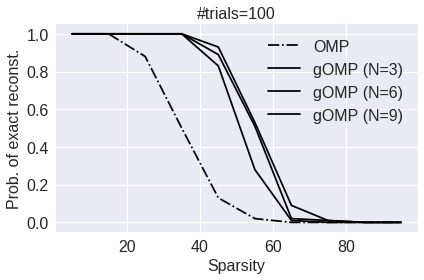

In [16]:
import matplotlib.pyplot as plt
plt.figure()

reconst = np.array(list(reconsts['OMP']['success'].values())) / reconsts['test_count']
plt.plot(reconsts['nnz'], reconst, 'ko-.', markersize=6, mec='k', mfc='None', label='OMP')

reconst = np.array(list(reconsts['gOMP3']['success'].values())) / reconsts['test_count']
plt.plot(reconsts['nnz'], reconst, 'ks-', markersize=6, mec='k', mfc='None', label='gOMP (N=3)')

reconst = np.array(list(reconsts['gOMP6']['success'].values())) / reconsts['test_count']
plt.plot(reconsts['nnz'], reconst, 'k*-', markersize=8, mec='k', mfc='None', label='gOMP (N=6)')

reconst = np.array(list(reconsts['gOMP9']['success'].values())) / reconsts['test_count']
plt.plot(reconsts['nnz'], reconst, 'k>-', markersize=6, mec='k', mfc='None', label='gOMP (N=9)')

#plt.plot(np.arange(n), x_est, 'ro', mfc = 'None', markersize=8, mec='red', mew=1, label='Estimated')
plt.legend(loc='lower left', shadow=False)
plt.title('#trials='+str(reconsts['test_count']), fontsize=16)
plt.xlabel("Sparsity", fontsize=16)
plt.ylabel("Prob. of exact reconst.", fontsize=16)
plt.legend(fontsize=16)
plt.tick_params(labelsize=16)

plt.tight_layout()
plt.savefig('gOMP_prob_reconst.pdf', bbox_inches='tight', dpi=300)
plt.savefig('gOMP_prob_reconst.eps', bbox_inches='tight', dpi=300)

plt.show()

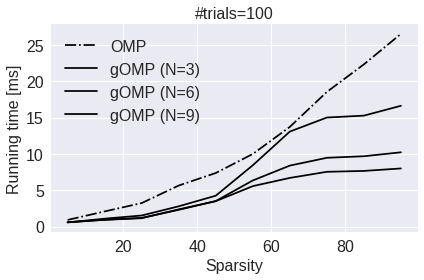

In [17]:
import matplotlib.pyplot as plt
plt.figure()
#plt.yscale("log")
from matplotlib.ticker import ScalarFormatter

reconst = np.array(list(reconsts['OMP']['time'].values())) / reconsts['test_count']
plt.plot(reconsts['nnz'], reconst*1000, 'ko-.', markersize=6, mec='k', mfc='None', label='OMP')

reconst = np.array(list(reconsts['gOMP3']['time'].values())) / reconsts['test_count']
plt.plot(reconsts['nnz'], reconst*1000, 'ks-', markersize=6, mec='k', mfc='None', label='gOMP (N=3)')

reconst = np.array(list(reconsts['gOMP6']['time'].values())) / reconsts['test_count']
plt.plot(reconsts['nnz'], reconst*1000, 'k*-', markersize=8, mec='k', mfc='None', label='gOMP (N=6)')

reconst = np.array(list(reconsts['gOMP9']['time'].values())) / reconsts['test_count']
plt.plot(reconsts['nnz'], reconst*1000, 'k>-', markersize=6, mec='k', mfc='None', label='gOMP (N=9)')

#plt.plot(np.arange(n), x_est, 'ro', mfc = 'None', markersize=8, mec='red', mew=1, label='Estimated')
plt.legend(loc='upper left', shadow=False)
plt.title('#trials='+str(reconsts['test_count']), fontsize=16)
plt.xlabel("Sparsity", fontsize=16)
plt.ylabel("Running time [ms]", fontsize=16)
plt.legend(fontsize=16)
plt.tick_params(labelsize=16)

#plt.gca().yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
#plt.gca().tick_params(labelsize=16)
#plt.gca().ticklabel_format(style='sci',axis='y',scilimits=(0,0))
plt.tight_layout()
plt.savefig('gOMP_runningtime.pdf', bbox_inches='tight', dpi=300)
plt.savefig('gOMP_runningtime.eps', bbox_inches='tight', dpi=300)
plt.show()